Imports and Hyperparameters


In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = ""
dataset_size= 160000 
test_portion=.1

corpus = []

1 Data


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

In [4]:
num_sentences = 0
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      
      
      list_item=[]
      
      list_item.append(row[5])
      
      if row[0] == '0':
        list_item.append(0)
      else:
        list_item.append(1)

      num_sentences = num_sentences + 1
      corpus.append(list_item)

     

print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
3200000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [5]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(dataset_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

split = int(test_portion * dataset_size)
train_sentences = sentences[split:dataset_size]
train_labels = labels[split:dataset_size]
test_sentences = sentences[0:split]
test_labels = labels[0:split]

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

train_seq = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)


training_padded = np.array(train_padded)
training_labels = np.array(train_labels)

testing_padded = np.array(test_padded)
testing_labels = np.array(test_labels)

def get_vocabsize(sentences):
  tokenizer_temp = Tokenizer()
  tokenizer_temp.fit_on_texts(sentences)

  word_index = tokenizer_temp.word_index
  vocab_size=len(word_index)

  return vocab_size, word_index
vocab_size, word_index = get_vocabsize(sentences)
     

print(vocab_size)
print(word_index['i'])

136223
1


*2 Get Embeddings from GloVe


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
    
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

3 Model


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           13622400  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

4 Plot Accuracy and Loss


<Figure size 432x288 with 0 Axes>

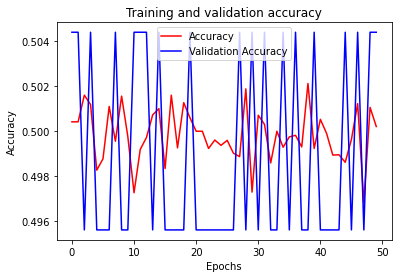

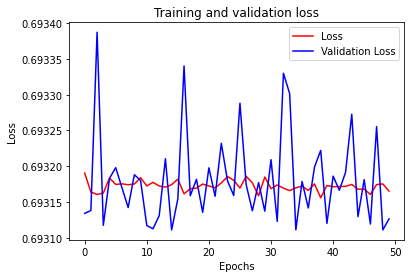

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
